# The unreasonable positive performance of minibatch optimal transport

## Building straight flows at inference time

In this notebook, we delve into the analysis of OT-CFM flows generated by optimal transport (OT), minibatch optimal transport, and entropically-regularized optimal transport in the context of the *8 Gaussian to 2 moons* task. For those seeking a comprehensive tutorial on Flow Matching, we recommend referring to our dedicated Flow Matching tutorial notebook.

Flow Matching relies on a conditioning variable $z$ drawn from a latent distribution $q$. There are several possible choices for $q$. A natural choice is to consider a uniform distribution. In our OT-CFM and SB-CFM methods, we defined $q$ as an optimal transport plan. Formally, our variable $z$ is a tuple of source and target variables that were drawn from an OT plan $\pi$ ($(x_0, x_1) \sim \pi$). The plan $\pi$ can be derived from the solution of optimal transport, or minibatch optimal transport, or entropically-regularized optimal transport. This notebook is dedicated to exploring the consequences of utilizing different optimal transport plans.

The Flow Matching method presented in this notebook is based on our paper [OT-CFM](https://arxiv.org/abs/2302.00482). The theoretical and practical study of minibatch OT (which is used by OT-CFM) can be found in the papers [Learning with minibatch Wasserstein](https://proceedings.mlr.press/v108/fatras20a.html) and [Minibatch optimal transport distances; analysis and applications](https://arxiv.org/abs/2101.01792). Consider citing these papers if you find our OT-CFM method useful!

Note from the authors: this is a beta turotial! Do not hesitate to suggest improvements through the opened issue https://github.com/atong01/conditional-flow-matching/issues/89

In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.optimal_transport import OTPlanSampler
from torchcfm.models.models import *
from torchcfm.utils import *
import matplotlib.pylab as pl
import ot


savedir = "models/8gaussian-moons"
os.makedirs(savedir, exist_ok=True)

# Optimal Transport

To generate new samples, our OT-CFM method relies on Optimal Transport. For sake of simplicity and completness, we start by recalling the OT definition that was presented in the notebook *Flow_matching_tutorial*.

To get straighter path, we can leverage the optimal transport (OT) theory. Indeed, as discussed in [(Peyré et al., chapter 7)](https://arxiv.org/abs/1803.00567), the OT problem can be reformulated as a minimal-path length problem. Thus, we want to leverage this property in order to produce straighter flows that would lead to a faster inference process.

The OT problem aims to minimize the displacement cost between two distributions. Formally, let $\alpha = \frac1n \sum_{i=1}^n \delta_{x_i}$ and $\beta = \frac1n \sum_{j=1}^n \delta_{z_j}$ represents the source and target distributions (i.e., they are sum of diracs). 

Optimal Transport is based on two key notions: $\textbf{Transport}$ and $\textbf{cost}$. Let's delve into the first concept.

To transport a distribution towards another, we examine their probabilistic representation. The distribution $\alpha$ and $\beta$ are sum of diracs with uniform weights. This implies that we can represent them as tuples of a position and a probability weight (i.e., $(x_i, \frac1n)_{i=1}^n$ and $(z_j, \frac1n)_{j=1}^n$)). To move $\alpha$ towards $\beta$, the task is to transport each individual sample mass $\frac1n$ from $\alpha$ to $\beta$.

To formalize this concept, we introduce a transport matrix, denoted as $\Pi$. Each row of $\Pi$ corresponds to a source sample, and each column represents a target sample. Thus, an element $\Pi_{ij}$ element represents the quantity of mass transported from $x_i$ and $z_j$. 

To ensure that each individual $\alpha$ sample is transported to $\beta$ (and vice-versa), the transport plan $\Pi$ must satisfy the following constraints: $\sum_j \Pi_{ij} = a_i = \frac1n$ and $\sum_i \Pi_{ij} = b_j = \frac1n$. It means that each sample's mass $\frac1n$ has been moved to the other distribution. These constraints guarantee the conservation of mass during the transport process.

Having established how to transport distributions, let's delve into the concept of a $\textbf{displacement cost}$. 

In the context of optimal transport, which aims to minimize the distance cost from $\alpha$ to $\beta$, we need a notion of distance. That is why we evaluate the distance between the supports of the source and target distributions (*i.e.*, $(x_i)_{i=1}^n$ for $\alpha$ and $(z_j)_{j=1}^n$ for $\beta$). This involves introducing a ground cost matrix $C$, where $C_{ij} = \|x_i - z_j\|$ measures the distance between the support points $x_i$ and $z_j$.

Bringing all the components together, the cost of moving $\alpha$ to $\beta$ is given by $\sum_{ij} \Pi_{ij} C_{ij} = \langle \Pi, C \rangle_F$.

As the OT problem seeks the minimal displacement cost, we solve the following problem: $$\Pi^\star=\text{argmin}_{\Pi \in U(\alpha, \beta)} \langle \Pi, C \rangle.$$

where $U(\alpha, \beta)$ represents the set of admissible transport plans satisfying the mass conservation constraints.

That is why, to produce a faster inference process, **we choose the latent distribution $q(x_0, x_1) = \Pi(x_0, x_1)$.**

In [2]:
total_sample = 1000
# We fix the source and the target distributions for all the examples
x0 = sample_8gaussians(total_sample)
x1 = sample_moons(total_sample)

# We pre-compute the ground cost matrix
M = torch.cdist(x0, x1)**2

ot_plan_list = []
num_iter = 20000
a, b = ot.unif(total_sample), ot.unif(total_sample)

ot_sampler = OTPlanSampler(method="exact")
pi = ot_sampler.get_map(x0, x1)
ot_plan_list.append(pi)

# Scaling OT-CFM with Minibatch Optimal Transport

However, the computational OT cost is cubical in the number of samples. Therefore, we cannot compute it for large datasets and we want to rely on minibatch OT approximation to train our OT-CFM model. 

The concept behind minibatch OT is straightforward. Instead of calculating OT between the entire distributions, we perform it between minibatches of source and target samples. In a formal sense, during each training iteration, a source and a target minibatch are drawn uniformly at random, and the OT problem is computed between them. However, this practical strategy introduces an expectation of OT problems between minibatches, thereby *changing the original OT problem*, as OT is no longer computed between the complete distributions. This alteration gives rise to theoretical drawbacks, with a notable one being that minibatch OT is no longer a distance between distributions (Proposition 3, [Fatras et al., 2020](https://proceedings.mlr.press/v108/fatras20a.html)). We report the reader for a full study on minibatch OT to the following references [Learning with minibatch Wasserstein](https://proceedings.mlr.press/v108/fatras20a.html) and [Minibatch optimal transport distances; analysis and applications](https://arxiv.org/abs/2101.01792).

## Building minibatch distributions

We recall the source and target distributions $\alpha = \frac1n \sum_{i=1}^n \delta_{x_i}$ and $\beta = \frac1n \sum_{j=1}^n \delta_{z_j}$ respectively. As we solve minibatch OT problems, we want to understand what happens to the transport plan between the full distributions $\alpha$ and $\beta$. Given that the OT problem takes distributions of samples as inputs, we need to establish the distribution of minibatches.

To achieve this, let $I = \{i_1, \cdots, i_m \}$ (resp. $J= \{j_1, \cdots, j_m \}$) denote a $m$-tuple of indices to draw a source (resp. target) minibatch. The source and target minibatch distributions (associated to tuples $I$ and $J$) are defined as $\alpha_I = \frac1m \sum_{i=i_1}^{i_m}\delta_{x_i}$ and $\beta_J = \frac1m \sum_{j=j_1}^{j_m} \delta_{z_j}$. Notably, these distributions are uniform distributions of size $m$a crucial aspect to ensure that, in the end, the entire $\alpha$ and $\beta$ distributions are transported. Therefore, our goal is to solve the minibatch OT problem $OT(\alpha_I, \beta_J)$. In practice, the minibatches are drawn uniformly at random as illustrated in the next function:

In [3]:
def mini_batch(data, batch_size):
    '''
    Select a subset of sample space according to measure
    with np.random.choice

    Parameters
    ----------
    - data : ndarray(N, d)
    - batch_size : int
        batch size 'm'

    Returns
    -------
    - minibatch : ndarray(ns, nt)
        minibatch of samples
    - sub_weights : ndarray(m,)
        distribution weights of the minibatch
    - id_batch : ndarray(N_data,)
        index of minibatch elements
    '''
    id_ = np.random.choice(np.shape(data)[0], batch_size, replace=False)
    sub_weights = ot.unif(batch_size)
    return data[id_], sub_weights, id_

## Building the minibatch OT matrix

For each pair of $I = (i_1,\ldots,i_m)$ and $J = (j_1,\ldots,j_m)$, consider the ground cost between minibatches defined by $C_{I, J} = (\|x_i - z_j\|^2)_{i_1 \leq i \leq i_m, j_1 \leq j \leq j_m}$. The minibatch OT problem between $\alpha_I$ and $\beta_J$ is defined as $\operatorname{OT}(\alpha_I, \beta_J) = \operatorname{min}_{\Pi \in U(\alpha_I, \beta_j)}\langle \Pi, C_{I,J} \rangle_F$. Therefore, the transport plan (denoted $\Pi_{I,J}$) is a $m \times m$ matrix and it can be lifted to an $n \times n$ matrix where all entries are zero except those indexed in $I \times J$:

$
\qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \Pi_{I,J}^n =  \left\{
    \begin{array}{ll}
        0 & \mbox{if $i$ (resp. $j$) is not in $I$ (resp. $J$)}\\
        \Pi_{i,j} & \mbox{else}
    \end{array}
\right.
$

Now that we have built a $n \times n$ matrix for a minibatch couple, we just need to average the $n \times n$ OT matrix computed between all possible minibatch couples. The complete minibatch OT matrix is defined as:

$$\overline{\Pi}^m  := \frac{(n-m)!^2}{n!^2} \sum_{I} \sum_{J} \Pi_{  I, J }^n.$$

The plan $\overline{\Pi}^m$ is an admissible transport plan,satisfying marginal constraints and ensuring the transport of all mass between $\alpha$ and $\beta$. However, it's crucial to note that, by construction, **it is not the optimal transport plan between $\alpha$ and $\beta$**. The following function demonstrates how you can update $\overline{\Pi}^m$ with the minibatch plan $\Pi_{I,J}$.

In [4]:
def update_plan(pi, pi_minibatch, id_a, id_b):
    '''
    Update the full mini batch transportation matrix

    Parameters
    ----------
    - pi : ndarray(ns, nt)
        full minibatch transportation matrix
    - pi_mb : ndarray(m, m)
        minibatch transportation plan
    - id_a : ndarray(m)
        selected samples from source
    - id_b : ndarray(m)
        selected samples from target

    Returns
    -------
    - pi : ndarray(ns, nt)
        updated transportation matrix
    '''
    for i,i2 in enumerate(id_a):
        for j,j2 in enumerate(id_b):
            pi[i2,j2] += pi_minibatch[i][j]
    return pi

## Approximating the minibatch OT plan

The computational complexity of minibatch OT is inherently combinatorial due to the numerous possible combinations of source and target minibatches. To decrease the computational cost, we approximate the minibatch OT plan in an incomplete manner (see Definition 3 and Eq. (7) from [Learning with minibatch Wasserstein](https://proceedings.mlr.press/v108/fatras20a.html)). The approach involves considering a fixed number of minibatch couples to compute the minibatch OT plan. For the purposes of this study, we utilize 20,000 iterations with different minibatch sizes (128 and 64). Formally, consider a sequence of $m$-tuple couples drawn uniformaly at random $D_K = (I^k, J^k)_{k=1}^K$, with $K=20000$. The incomplete Minibatch OT plan $\widetilde{\Pi}_K^m$ is computed with the following sum:

$$\widetilde{\Pi}_K^m :=  \frac1K \sum_{  (I, J)  \in D_K  }  \Pi_{  I, J }^n.$$

Theoretically, this incomplete estimators approaches the true MBOT plan with a rate of $\mathcal{O}(1/K)$ as the number of minibatch couples $K$ increases (Theorem 2 from [Learning with minibatch Wasserstein](https://proceedings.mlr.press/v108/fatras20a.html)).

The following function shows how to compute the incomplete minibatch OT plan $\widetilde{\Pi}_K^m$.

In [5]:
def compute_incomplete_plan(xs, xt, a, b, bs, K, C, lambd=1e-1, method='exact'):
    '''
    Compute the minibatch gamma with stochastic source and target

    Parameters
    ----------
    - xs : ndarray(ns, d)
        source data
    - xt : ndarray(nt, d)
        target data
    - a : ndarray(ns)
        source distribution weights
    - b : ndarray(nt)
        target distribution weights
    - bs : int
        batch size
    - K : int
        number of batch couples
    - C : ndarray(ns, nt)
        cost matrix
    - lambda : float
        entropic reg parameter
    - method : char
        name of method (entropic or emd)

    Returns
    -------
    - incomplete_pi : ndarray(ns, nt)
        incomplete minibatch OT matrix
    '''
    incomplete_pi = np.zeros((np.shape(xs)[0], np.shape(xt)[0]))
    for i in range(K):
        # Select a source and target mini-batch couple
        sub_xs, sub_weights_a, id_a = mini_batch(xs, bs)
        sub_xt, sub_weights_b, id_b = mini_batch(xt, bs)
        
        # compute ground cost between minibatches
        mb_C = C[id_a,:][:,id_b]
        # The minibatch Cost could be computed on the fly instead of using the full-size ground cost
        
        # Solve the OT problem between minibatches
        if method == 'exact':
            G0 = ot.emd(sub_weights_a, sub_weights_b, mb_C.copy())

        elif method == 'entropic':
            G0 = ot.sinkhorn(sub_weights_a, sub_weights_b, mb_C, lambd)

        # Update the transport plan
        incomplete_pi = update_plan(incomplete_pi, G0, id_a, id_b)

    return (1/K) * incomplete_pi

# Computing different OT plans

We now compute incomplete minibatch OT plans with a minibatch size of 128 and 64.

In [6]:
# Compuete incomplete mbot plan for several batch sizes
batch_size_list = [128, 64]

for i, batch_size in enumerate(batch_size_list):

    incomplete_mbot_plan = compute_incomplete_plan(x0, x1, a, b, batch_size, num_iter, M.numpy())
    ot_plan_list.append(incomplete_mbot_plan)

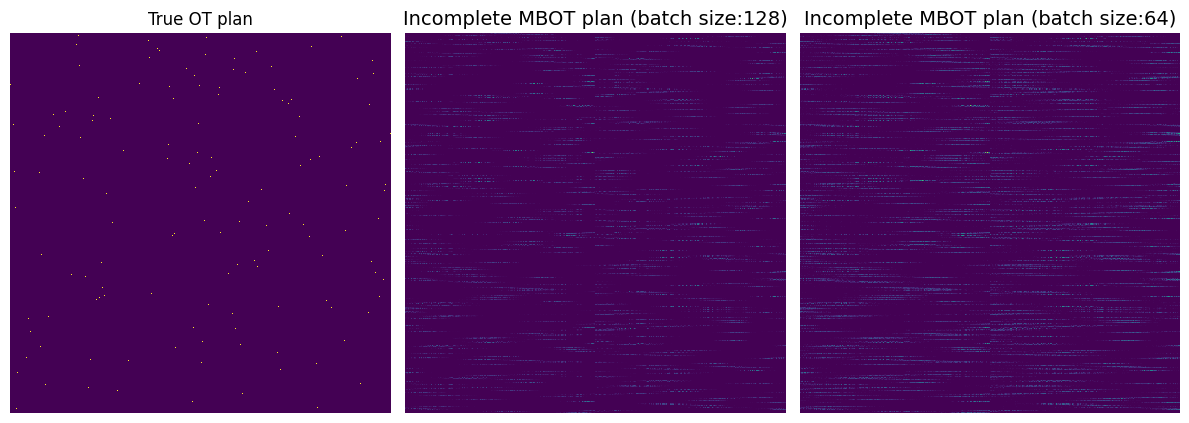

In [7]:
pl.figure(figsize=(12,5))

for i in range(3):
    pl.subplot(1,3,i+1)
    pl.imshow(ot_plan_list[i], interpolation='nearest')
    pl.axis('off')
    if i==0:
        pl.title('True OT plan')
    else:
        batch_size = batch_size_list[i-1]
        pl.title('Incomplete MBOT plan (batch size:{})'.format(batch_size), fontsize=14)
    pl.tight_layout()

As evident from the results,  the minibatch approximation leads to denser transport plans where the number of connections between samples increases as the batch size decreases. Furthermore, the intensity of these connections tend to be close to uniform for small minibatch sizes. In the special case of a minibatch size of $1$, the minibatch OT plan would be uniform. That is why the minibatch approximation might lead our inference flows to be curved.

# Training OT-CFM with different OT plans

Now that we know how to define the minibatch OT plan, we can compare their respective influcence on our OT-CFM method. We will train OT-CFM with the exact OT plan and with two MBOT plans for minibatch sizes of 128 and 64. 

20000: loss 0.032 time 318.14
20000: loss 0.372 time 250.18
20000: loss 0.701 time 243.02
CPU times: user 11min 12s, sys: 2min 14s, total: 13min 27s
Wall time: 13min 33s


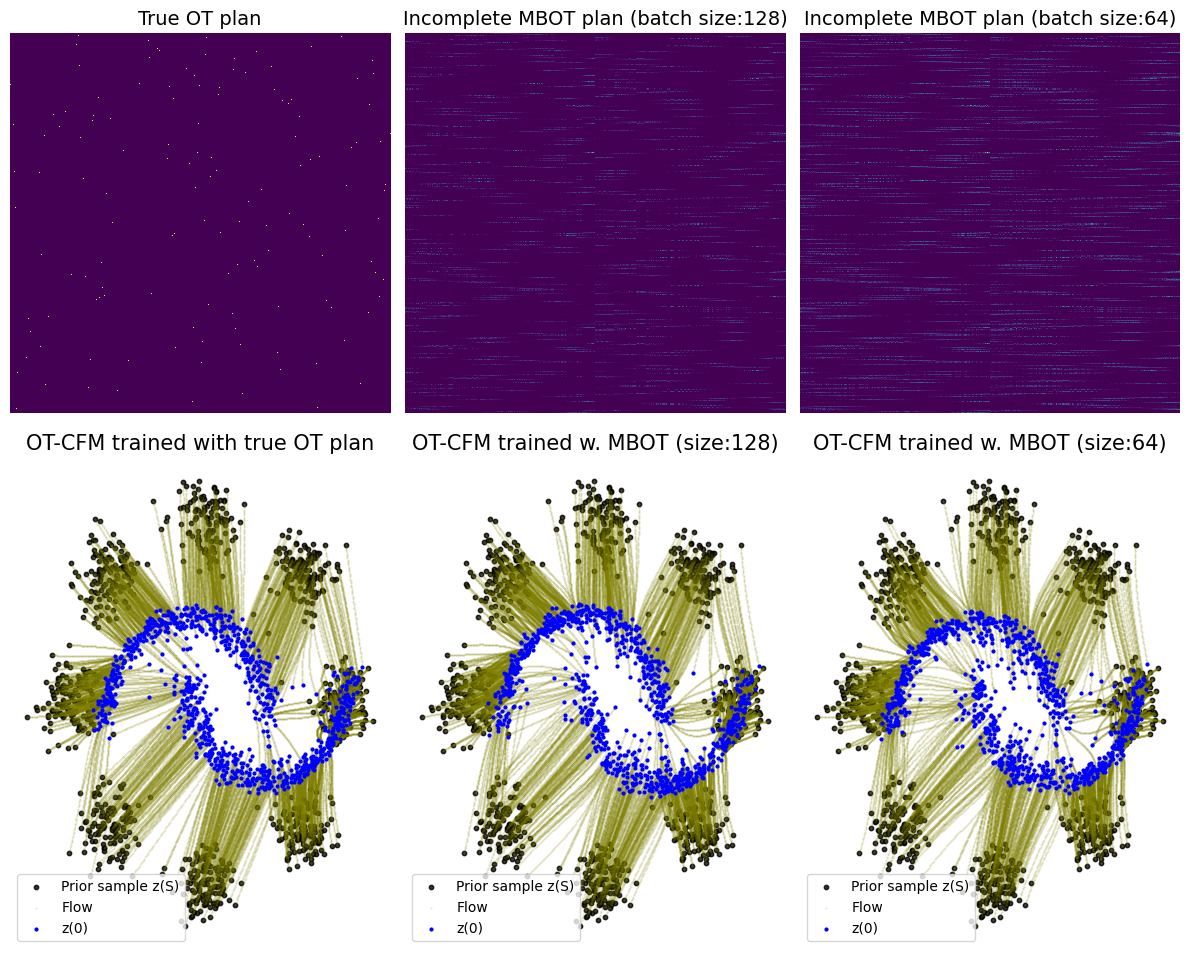

In [8]:
%%time
sigma = 0.1
dim = 2
pl.figure(3, figsize=(12,10))
batch_size = 128

for i, mbot_plan in enumerate(ot_plan_list):

    model = MLP(dim=dim, time_varying=True)
    optimizer = torch.optim.Adam(model.parameters())
    FM = ConditionalFlowMatcher(sigma=sigma)

    ot_sampler = OTPlanSampler(method="exact")

    start = time.time()
    for k in range(20000):
        optimizer.zero_grad()

        indices_i, indices_j = ot_sampler.sample_map(mbot_plan, batch_size=batch_size, replace=False)
        batch_x0, batch_x1 = x0[indices_i], x1[indices_j]

        t, xt, ut = FM.sample_location_and_conditional_flow(batch_x0, batch_x1)

        vt = model(torch.cat([xt, t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

    end = time.time()
    print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
    start = end
    node = NeuralODE(
        torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
    )
    with torch.no_grad():
        traj = node.trajectory(
            x0,
            t_span=torch.linspace(0, 1, 100),
        )
        
        
        pl.subplot(2,3,i+1)
        pl.imshow(ot_plan_list[i], interpolation='nearest')
        pl.axis('off')
        if i==0:
            pl.title('True OT plan', fontsize=14)
        else:
            batch_size = batch_size_list[i-1]
            pl.title('Incomplete MBOT plan (batch size:{})'.format(batch_size), fontsize=14)
        
        
        plt.subplot(2,3,i+4)
        traj = traj.cpu().numpy()
        plt.scatter(traj[0, :total_sample, 0], traj[0, :total_sample, 1], s=10, alpha=0.8, c="black")
        plt.scatter(traj[:, :total_sample, 0], traj[:, :total_sample, 1], s=0.2, alpha=0.2, c="olive")
        plt.scatter(traj[-1, :total_sample, 0], traj[-1, :total_sample, 1], s=4, alpha=1, c="blue")
        plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
        plt.xticks([])
        plt.yticks([])
        pl.axis('off')
        if i==0:
            pl.title('OT-CFM trained with true OT plan', fontsize=15)
        else:
            pl.title('OT-CFM trained w. MBOT (size:{})'.format(batch_size), fontsize=15)
        pl.tight_layout()
#pl.savefig('OT_CFM_different_MBOT_plan.png')

Interestingly, OT-CFM trained with a minibatch OT plan leads to straight flows on this 2D example, even for small minibatch sizes. Our experiments on Cifar10 further support this observation, demonstrating that fewer inference steps are needed to achieve competitive Frechet Inception Distance (FID) compared to I-CFM.

Despite being an approximation, minibatch OT has proven to be a performing technique and has found applications in various machine learning tasks. Early work on [GANs](https://proceedings.mlr.press/v84/genevay18a.html) and [domain adaptation](https://arxiv.org/abs/1803.10081) used minibatch OT.

## SB-CFM: OT-CFM trained with Entropic OT

In the upcoming section, we proceed to train OT-CFM with the entropic OT (EOT) plan. The EOT plan is the solution of the following problem:

$$\Pi_{\varepsilon} = \text{argmin}_{\Pi \in U(\alpha, \beta)} \langle \Pi, C \rangle - \varepsilon H(\Pi),$$

where $H$ is the entropy function. We refer the reader to [(Peyré et al., chapter 4)](https://arxiv.org/abs/1803.00567) for a full discussion on the entropically-regularized OT problem.

The motivation behind utilizing the entropic OT plan instead of the exact OT plan lies in its connection to the Schrödinger Bridge problem. The Schrödinger Bridge problem seeks the most likely evolution between a source and target probability distributions under a given reference process. This problem has gained attention in the machine learning community recently [(de Bortoli et al.)](https://arxiv.org/abs/2106.01357). When OT-CFM is trained with $\Pi_\varepsilon$, it aligns with the probability flow of the Schrödinger Bridge problem.

We aim to assess the impact of various entropically-regularized OT plans on the inference of our OT-CFM method. Specifically, we explore three different regularization strengths: $\varepsilon=\{1, 10, 100\}$.

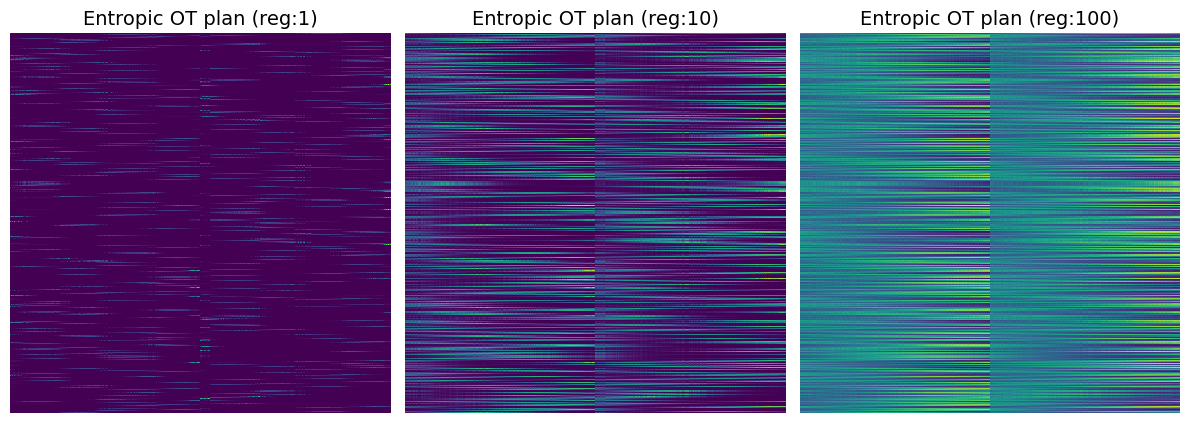

In [9]:
reg_list = [1, 10, 100]

pl.figure(3, figsize=(12,5))

x0 = sample_8gaussians(1000)
x1 = sample_moons(1000)
    
for i, reg in enumerate(reg_list):
    ot_sampler = OTPlanSampler(method="sinkhorn", reg=reg)

    entropic_ot_plan = ot_sampler.get_map(x0, x1)
    pl.subplot(1,3,i+1)
    pl.imshow(entropic_ot_plan, interpolation='nearest')
    pl.axis('off')
    pl.title('Entropic OT plan (reg:{})'.format(reg), fontsize=14)
    pl.tight_layout()


When employing small regularization coefficients $\varepsilon$,plan closely approximates the true OT plan, therefore SB-CFM would have the same behavior as OT-CFM. However, as the coefficient increases, the EOT plan converges towards the uniform plan. In this scenario, we would essentially revert to our Independent-CFM method. 

20000: loss 0.250 time 260.33
20000: loss 2.303 time 266.04
20000: loss 7.426 time 237.14
CPU times: user 10min 40s, sys: 2min 7s, total: 12min 48s
Wall time: 12min 49s


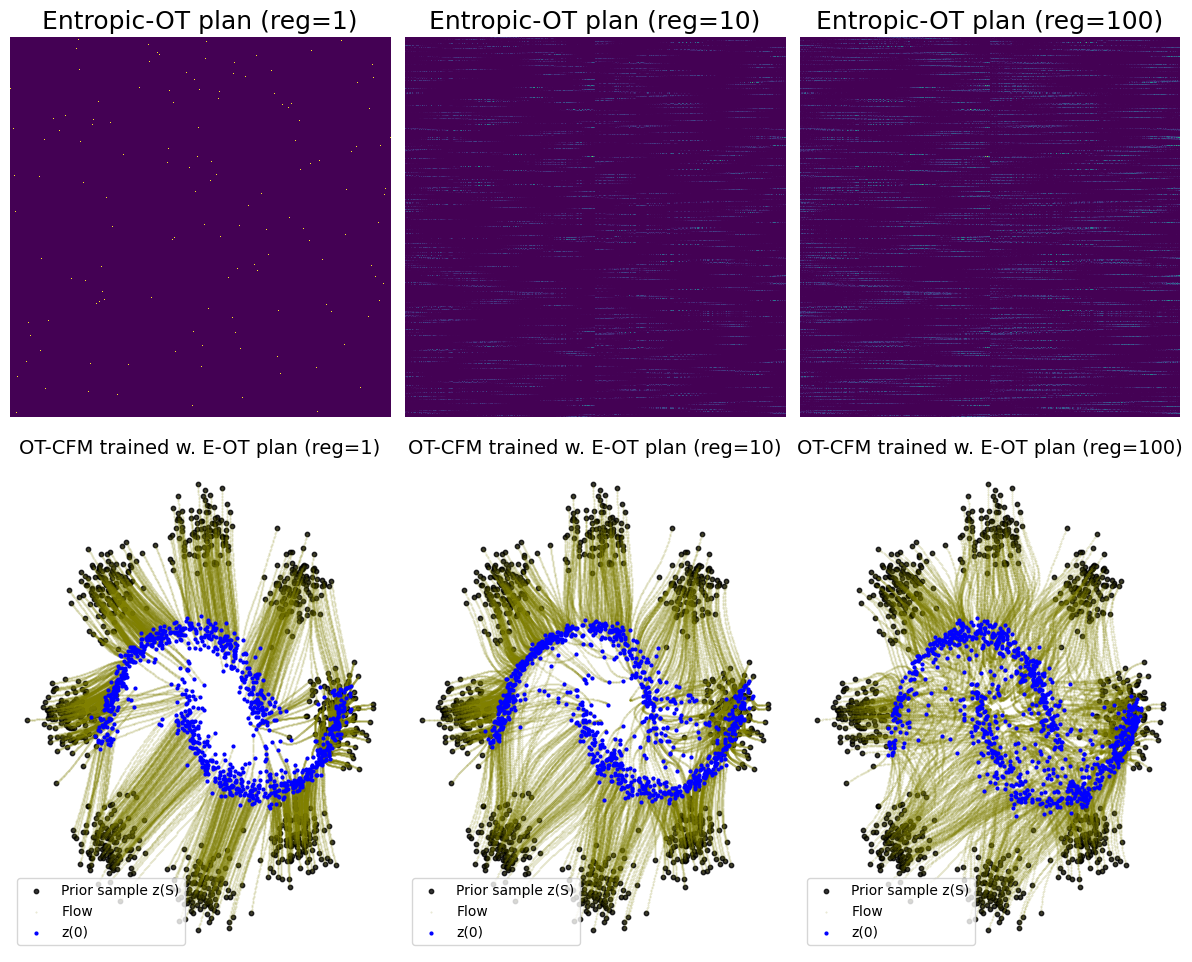

In [10]:
%%time
sigma = 0.1
dim = 2
batch_size = 128

pl.figure(3, figsize=(12,10))

for i, reg in enumerate(reg_list):
    model = MLP(dim=dim, time_varying=True)
    optimizer = torch.optim.Adam(model.parameters())
    FM = ConditionalFlowMatcher(sigma=sigma)

    ot_sampler = OTPlanSampler(method="sinkhorn", reg=reg)

    pi = ot_sampler.get_map(x0, x1)

    start = time.time()
    for k in range(20000):
        optimizer.zero_grad()

        indices_i, indices_j = ot_sampler.sample_map(pi, batch_size=batch_size, replace=False)
        batch_x0, batch_x1 = x0[indices_i], x1[indices_j]

        t, xt, ut = FM.sample_location_and_conditional_flow(batch_x0, batch_x1)

        vt = model(torch.cat([xt, t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()


    end = time.time()
    print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
    start = end
    node = NeuralODE(
        torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
    )
    with torch.no_grad():
        traj = node.trajectory(
            x0,
            t_span=torch.linspace(0, 1, 100),
        )
        pl.subplot(2,3,i+1)
        pl.imshow(ot_plan_list[i], interpolation='nearest')
        pl.axis('off')
        pl.title('Entropic-OT plan (reg={})'.format(reg), fontsize=18)
        
        
        plt.subplot(2,3,i+4)
        traj = traj.cpu().numpy()
        plt.scatter(traj[0, :total_sample, 0], traj[0, :total_sample, 1], s=10, alpha=0.8, c="black")
        plt.scatter(traj[:, :total_sample, 0], traj[:, :total_sample, 1], s=0.2, alpha=0.2, c="olive")
        plt.scatter(traj[-1, :total_sample, 0], traj[-1, :total_sample, 1], s=4, alpha=1, c="blue")
        plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
        plt.xticks([])
        plt.yticks([])
        pl.axis('off')
        pl.title('OT-CFM trained w. E-OT plan (reg={})'.format(reg), fontsize=14)
        pl.tight_layout()
pl.savefig('OT_CFM_different_entropic_OT_plan.png')

As anticipated, when we opt for a small regularization parameter $\varepsilon$, we regain an OT plan that closely aligns with the true OT plan, yielding straight flows like for OT-CFM. However when $\varepsilon \to \infty$, becomes a uniform matrix, causing SB-CFM's flows to converge towards I-CFM's flows. 

# Entropy minibatch optimal transport

Throughout this notebook, we've consistently observed that both entropically regularized optimal transport and minibatch OT produce a similar effect on the transport plan: they increase the number of connections between source and target samples. The addition of entropically regularized optimal transport and minibatch OT would lead to an excessively dense transport plan, recovering I-CFM even faster. In our experiments, we have observed that minibatch with exact OT outputs better results than minibatch with entropically-regularized minibatch OT. Therefore, we recommend relying on a minibatch OT computation without entropic regularization.